# 5.0 10X Genomics PBMC 3K Dataset

In [1]:
from clustergrammer_widget import *
net = Network(clustergrammer_widget)
df = {}

import clustergrammer_groupby as cby
import gene_exp_10x

In [2]:
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline 

### Load Data

In [3]:
df['ge-ini'] = gene_exp_10x.load_gene_exp_to_df('../data/pbmc3k_filtered_gene_bc_matrices/hg19/')
df['ge-ini'].shape

(32738, 2700)

In [4]:
all_genes = df['ge-ini'].index.tolist()
print(len(all_genes))
keep_genes = [x for x in all_genes if 'RPL' not in x]
keep_genes = [x for x in keep_genes if 'RPS' not in x]
print(len(keep_genes))

df['ge'] = df['ge-ini'].loc[keep_genes]
df['ge'].shape

# Removing Mitochondrial Genes
list_mito_genes = ['MTRNR2L11', 'MTRF1', 'MTRNR2L12', 'MTRNR2L13', 'MTRF1L', 'MTRNR2L6', 'MTRNR2L7',
                'MTRNR2L10', 'MTRNR2L8', 'MTRNR2L5', 'MTRNR2L1', 'MTRNR2L3', 'MTRNR2L4']

all_genes = df['ge'].index.tolist()
mito_genes = [x for x in all_genes if 'MT-' == x[:3] or 
             x.split('_')[0] in list_mito_genes]
print(mito_genes)

keep_genes = [x for x in all_genes if x not in mito_genes]
df['ge'] = df['ge'].ix[keep_genes]

# normalize by UMI count
barcode_umi_sum = df['ge'].sum()
df['ge'] = df['ge'].div(barcode_umi_sum)

32738
32546
['MTRNR2L11', 'MTRNR2L12', 'MTRNR2L13', 'MTRF1L', 'MTRNR2L6', 'MTRNR2L10', 'MTRNR2L7', 'MTRNR2L5', 'MTRNR2L8', 'MTRF1', 'MTRNR2L4', 'MTRNR2L1', 'MTRNR2L3', 'MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']


/Users/nickfernandez/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [5]:
net.load_df(df['ge'])
net.normalize(axis='row', norm_type='zscore')
net.swap_nan_for_zero()
df['ge-z'] = net.export_df()
df['ge-z'].shape

(32520, 2700)

In [6]:
import clustergrammer_widget2
from clustergrammer import *
net = Network()

In [7]:
net.load_df(df['ge'])
net.filter_N_top(inst_rc='row', N_top=250, rank_type='var')
net.normalize(axis='row', norm_type='zscore')
net.random_sample(axis='col', num_samples=250, random_state=99)
net.clip(lower=-5, upper=5)
net.cluster()
net_json = net.export_viz_to_widget()
w = clustergrammer_widget2.ExampleWidget(network=net_json)
w

### Visualize Original Dataset

In [6]:
net.load_df(df['ge'])
net.filter_N_top(inst_rc='row', N_top=250, rank_type='var')
net.normalize(axis='row', norm_type='zscore')
net.random_sample(axis='col', num_samples=250, random_state=99)
net.clip(lower=-5, upper=5)
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


### Load NM'3337 gene sigantures

In [7]:
net.load_file('../data/cell_type_signatures/nm3337_broad_cell_type_sigs.txt')
df['bct-sig'] = net.export_df()
print(df['bct-sig'].shape)

net.load_file('../data/cell_type_signatures/nm3337_narrow_cell_type_sigs.txt')
df['nct-sig'] = net.export_df()
print(df['nct-sig'].shape)

(523, 9)
(523, 22)


In [8]:
net.load_df(df['nct-sig'])
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [9]:
sig_rows = df['bct-sig'].index.tolist()
clean_sig_rows = [x.split('_')[0] for x in sig_rows]
print(len(clean_sig_rows), len(list(set(clean_sig_rows))))

523 523


In [10]:
ge_rows = df['ge'].index.tolist()
clean_ge_rows = [x.split('_')[0] for x in ge_rows]
print(len(ge_rows), len(list(set(clean_ge_rows))))

32520 32425


In [11]:
ser_ge_rows = pd.Series(clean_ge_rows)

In [12]:
gene_name_count = ser_ge_rows.value_counts(ascending=False)
duplicate_genes = gene_name_count[gene_name_count > 1].index.tolist()
len(duplicate_genes)

91

### only add unique index to duplicate genes

In [13]:
dup_index = {}
new_rows = []
for inst_row in clean_ge_rows:
    
    # add index to non-unique genes
    if inst_row in duplicate_genes:
        
        # calc non-unique index
        if inst_row not in dup_index:
            dup_index[inst_row] = 1
        else:
            dup_index[inst_row] = dup_index[inst_row]  + 1
            
        new_row = inst_row + '_' + str(dup_index[inst_row])
        
    else:
        new_row = inst_row
        
    new_rows.append(new_row)

In [14]:
print(len(new_rows))
print(len(list(set(new_rows))))

32520
32520


In [15]:
# df['ge'].index = new_rows
# df['ge-z'].index = new_rows

# Predict Cell Types using NM3337 Signatures

In [16]:
rows = df['nct-sig'].index.tolist()
new_rows = [x.split('_')[0] for x in rows]
df['nct-sig'].index = new_rows

In [17]:
# df['nct-sig'].columns.tolist()

In [18]:
rows = df['bct-sig'].index.tolist()
new_rows = [x.split('_')[0] for x in rows]
df['bct-sig'].index = new_rows

In [19]:
# rows = df['ge-z'].index.tolist()
# new_rows = [x.split('_')[0] for x in rows]
# df['ge-z'].index = new_rows

In [20]:
df['pred_cat'], df['sig_sim'], y_info = cby.predict_cats_from_sigs(df['ge-z'], df['bct-sig'], 
                                                                   predict_level='Cell Type', unknown_thresh=0.05)

In [21]:
net.load_df(df['pred_cat'])
net.set_cat_color(axis='col', cat_index=1, cat_name='Cell Type: T cells CD8', inst_color='red')
net.random_sample(axis='col', num_samples=250, random_state=99)
net.clip(lower=-5, upper=5)
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [22]:
df['ge-cat'] = deepcopy(df['ge'])
df['ge-cat'].shape

(32520, 2700)

In [23]:
# transfer predicted categories to full dataset and add UMI count
cat_cols = df['pred_cat'].columns.tolist()
df['ge-cat'].columns = cat_cols

# new_cols = [(x[0], x[1], 'UMI: ' + str(barcode_umi_sum[x[0]])) for x in cat_cols]

df['ge-cat-umi'] = deepcopy(df['ge-cat'])
# df['ge-cat-umi'].columns = new_cols
# print(df['ge-cat-umi'].shape)

In [24]:
net.load_df(df['ge-cat-umi'])
net.set_cat_color(axis='col', cat_index=1, cat_name='Cell Type: T cells CD8', inst_color='red')
net.filter_N_top(inst_rc='row', N_top=250, rank_type='var')
net.random_sample(axis='col', num_samples=250, random_state=99)
net.normalize(axis='row', norm_type='zscore')
df['tmp'] = net.export_df()
net.clip(lower=-5, upper=5)
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [25]:
df['tmp'].shape

(250, 250)

# Make more general comparison

AUC 0.8255516532848226


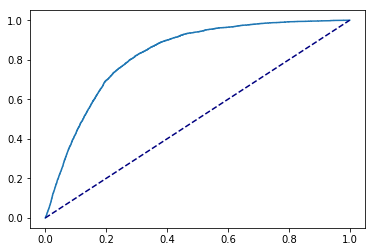

<Figure size 720x720 with 0 Axes>

In [26]:
sim_dict, pval_dict, roc_data = cby.sim_same_and_diff_category_samples(df['tmp'])

In [27]:
sim_dict['same'].mean()

0.07964329422023413

In [28]:
sim_dict['diff'].mean()

-0.03335896723704645

In [29]:
pval_dict

{'ttest': 0.0, 'mannwhitney': 0.0}

### Signature Prediction

In [30]:
%%time
net.load_df(df['ge-cat-umi'])
net.filter_N_top(inst_rc='row', N_top=1000, rank_type='var')
net.normalize(axis='row', norm_type='zscore')
df['ge-cat-umi-z'] = net.export_df() 

df['cat-sig'], keep_genes, keep_genes_dict = cby.generate_signatures(
                                                          df['ge-cat-umi-z'], 
                                                          'Cell Type', pval_cutoff=0.05)

df['pred_cat'], df['sig_sim'], y_info = cby.predict_cats_from_sigs(df['ge-cat-umi-z'], 
                                                                   df['cat-sig'])

df['conf'], populations, ser_correct, fraction_correct = cby.confusion_matrix_and_correct_series(y_info)
print('fraction correct: ', fraction_correct)
print(f1_score(y_info['true'], y_info['pred'], average='macro'))
print(f1_score(y_info['true'], y_info['pred'], average='micro'))
print(f1_score(y_info['true'], y_info['pred'], average='weighted'))

fraction correct:  0.7340740740740741
0.6193963431631915
0.7340740740740741
0.7181067481574941
CPU times: user 4.91 s, sys: 2.05 s, total: 6.97 s
Wall time: 3.94 s


/Users/nickfernandez/Documents/clustergrammer_signature_methods/notebooks/clustergrammer_groupby.py:139: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  df_gene_pval = pd.concat(gene_pval_dict, axis=1)


### Shuffle

In [31]:
# %%time
# num_shuffles = 10
# perform_ser = cby.compare_performance_to_shuffled_labels(df['ge-cat-umi-z'], 'Cell Type', 
#                                                          num_shuffles=num_shuffles)
# print('mean: ', perform_ser.mean(), 'std: ', perform_ser.std())
# print('previously calc real performance: ', fraction_correct)

/Users/nickfernandez/Documents/clustergrammer_signature_methods/notebooks/clustergrammer_groupby.py:139: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  df_gene_pval = pd.concat(gene_pval_dict, axis=1)


performance (fraction correct) of unshuffled: 0.7340740740740741
mean:  0.3645185185185185 std:  0.02519414026219763
previously calc real performance:  0.7340740740740741
CPU times: user 13.1 s, sys: 2.1 s, total: 15.2 s
Wall time: 5.85 s


In [32]:
perform_ser[perform_ser > fraction_correct]

Series([], dtype: float64)

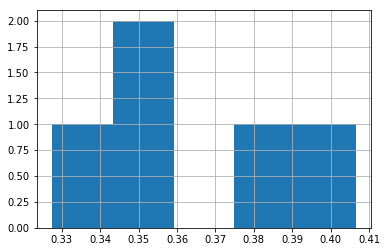

In [33]:
perform_ser.hist()

In [34]:
(fraction_correct - perform_ser.mean())/perform_ser.std()

14.668313810654322

# Same-Cat vs Diff-Cat Sample Similarity

In [35]:
net.load_df(df['ge-cat-umi'])
net.filter_N_top(inst_rc='row', N_top=1000, rank_type='var')
net.normalize(axis='row', norm_type='zscore')
# net.random_sample(axis='col', num_samples=750, random_state=99)
df['ge-small'] = net.export_df()
print(df['ge-small'].shape)

(1000, 2700)


In [36]:
%%time
sim_dict, pval_dict, roc_data = cby.sim_same_and_diff_category_samples(df['ge-small'])

KeyboardInterrupt: 

In [37]:

# sim_dict, pval_dict = cby.sim_same_and_diff_category_samples(df['ge-small'])

### need to normalize histograms

In [ ]:
hist = {}
hist['diff'] = sim_dict['diff'].hist(bins=100, range=(-0.2,0.5))

In [ ]:
hist['same'] = sim_dict['same'].hist(bins=100, range=(-0.2,0.5))

In [ ]:
sim_dict['diff'].mean()

In [ ]:
sim_dict['same'].mean()

### Calc ROC Curve

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
sim_dict['same'].shape

In [ ]:
true_index = list(np.ones(sim_dict['same'].shape[0]))
false_index = list(np.zeros(sim_dict['diff'].shape[0]))
y_true = true_index + false_index
print(len(y_true))

In [ ]:
true_val = list(sim_dict['same'].get_values())
false_val = list(sim_dict['diff'].get_values())
y_score = true_val + false_val
print(len(y_score))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_score)

In [ ]:
fpr.shape

In [ ]:
tpr.shape

### Plot ROC Curve

In [ ]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.figure(figsize=(10,10))

In [ ]:
from sklearn.metrics import auc

In [ ]:
auc(fpr, tpr)

In [ ]:
hist['diff']

In [ ]:
x = range(1000)

In [ ]:
np.histogram(sim_dict['diff'], )

In [ ]:
sim_dict['diff'].hist()
sim_dict['same'].hist()

In [ ]:
print(sim_dict['diff'].sum(), sim_dict['same'].sum())

In [ ]:
print(sim_dict['diff'].mean(), sim_dict['same'].mean())